In [ ]:
!pip install praw vaderSentiment textblob folium geopy spacy folium geonamescache python-dotenv
!python -m spacy download en_core_web_sm


     --------------------------------------- 12.8/12.8 MB 13.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


# Necessary Imports

In [2]:
import praw
import pandas as pd
import re
import nltk
import json
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
from folium.plugins import HeatMap
import folium


# Setting API Keys

In [ ]:
import os
# Ensure nltk stopwords are downloaded
nltk.download('stopwords')
nltk.download('punkt')

# Reddit API Credentials
REDDIT_CLIENT_ID = os.getenv("REDDIT_CLIENT_ID ")
REDDIT_CLIENT_SECRET = os.getenv("REDDIT_CLIENT_SECRET")
REDDIT_USER_AGENT =os.getenv("REDDIT_USER_AGENT")

# Authenticate with Reddit API
reddit = praw.Reddit(
    client_id=REDDIT_CLIENT_ID,
    client_secret=REDDIT_CLIENT_SECRET,
    user_agent=REDDIT_USER_AGENT
)

# Define crisis-related keywords and subreddits
KEYWORDS = ["depressed", "suicidal", "addiction help", "self-harm", "overwhelmed", "hopeless", "anxious", "panic attack", "lonely", "burnout", "relapse", "therapy", "insomnia", "crying", "isolation"]
SUBREDDITS = ["depression", "mentalhealth", "SuicideWatch", "Anxiety", "Addiction"]


api_key = os.getenv("OPENCAGE_API_KEY")


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aggar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\aggar\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Task 1 and Sentiment Analysis

In [ ]:
# Function to clean text
def clean_text(text):
    text = re.sub(r'http\S+', '', text)  
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  
    text = text.lower()
    words = text.split()
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    return ' '.join(words)

# Extract Reddit data
def fetch_reddit_posts():
    data = []
    for subreddit_name in SUBREDDITS:
        subreddit = reddit.subreddit(subreddit_name)
        for post in subreddit.hot(limit=50):
            cleaned_text = clean_text(post.title + " " + post.selftext)
            data.append([post.id, post.created_utc, cleaned_text, post.score, post.num_comments, post.num_comments * 2])
    return pd.DataFrame(data, columns=['ID', 'Timestamp', 'Content', 'Upvotes', 'Comments', 'Shares'])

# Sentiment Analysis using VADER and TextBlob
def analyze_sentiment(text):
    analyzer = SentimentIntensityAnalyzer()
    vader_score = analyzer.polarity_scores(text)['compound']
    blob_score = TextBlob(text).sentiment.polarity
    final_score = (vader_score + blob_score) / 2  # Averaging both scores
    return 'Positive' if final_score > 0.05 else 'Negative' if final_score < -0.05 else 'Neutral'

# Crisis Risk Classification
def classify_risk(text):
    high_risk_phrases = ["i dont want to be here", "ending it all", "no reason to live", "i cant take it anymore"]
    moderate_phrases = ["feeling lost", "need help", "struggling with life", "im not okay"]
    low_risk_phrases = ["stressed out", "having a bad day", "just need to talk"]
    
    text_lower = text.lower()
    for phrase in high_risk_phrases:
        if phrase in text_lower:
            return 'High-Risk'
    for phrase in moderate_phrases:
        if phrase in text_lower:
            return 'Moderate Concern'
    for phrase in low_risk_phrases:
        if phrase in text_lower:
            return 'Low Concern'
    return 'Minimal Concern'

# Extract embeddings using TF-IDF
def get_tfidf_embeddings(corpus):
    vectorizer = TfidfVectorizer(max_features=500)
    return vectorizer.fit_transform(corpus).toarray()

# Geolocation using geopy
def geocode_location(text):
    geolocator = Nominatim(user_agent="geoapi", timeout=5)
    match = re.search(r'in ([A-Za-z]+)', text)
    if match:
        location = match.group(1)
        try:
            loc = geolocator.geocode(location)
            if loc:
                return (loc.latitude, loc.longitude)
        except GeocoderTimedOut:
            return None
    return None

# Run the pipeline
data = fetch_reddit_posts()
data['Sentiment'] = data['Content'].apply(analyze_sentiment)
data['Risk_Level'] = data['Content'].apply(classify_risk)
data['Geolocation'] = data['Content'].apply(geocode_location)

# Unpack valid locations
data[['Latitude', 'Longitude']] = pd.DataFrame(data['Geolocation'].dropna().tolist(), index=data['Geolocation'].dropna().index)
data.drop(columns=['Geolocation'], inplace=True)






# Save cleaned data
data.to_csv("cleaned_reddit_posts_final.csv", index=False)
data.to_json("cleaned_reddit_posts_final.json", orient='records')





# Task 2 Plot

Sentiment and risk level distributions saved as 'distribution_plots.png'.


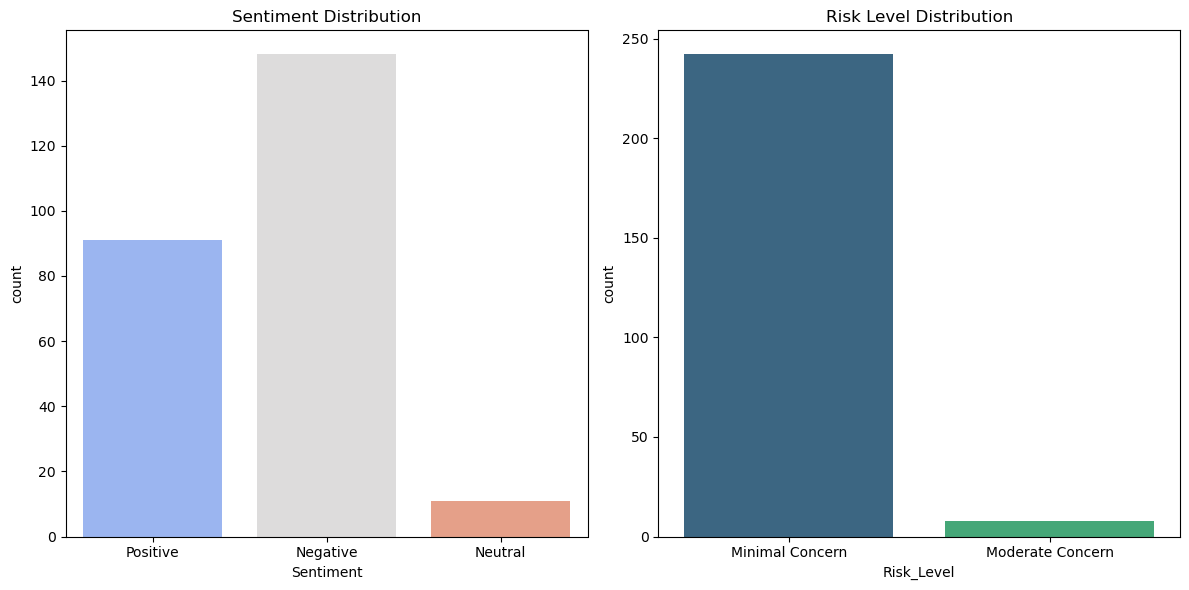

Data extraction, processing, and mapping completed!


In [5]:
# Visualization of Sentiment and Risk Level Distributions
def plot_distributions(df):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.countplot(x=df['Sentiment'], palette='coolwarm')
    plt.title('Sentiment Distribution')
    
    plt.subplot(1, 2, 2)
    sns.countplot(x=df['Risk_Level'], palette='viridis')
    plt.title('Risk Level Distribution')
    
    plt.tight_layout()
    plt.savefig("distribution_plots.png")
    print("Sentiment and risk level distributions saved as 'distribution_plots.png'.")
    plt.show()






plot_distributions(data)
print("Data extraction, processing, and mapping completed!")


# Task 3 

In [ ]:
import pandas as pd
import folium
from folium.plugins import HeatMap, MarkerCluster
from geopy.geocoders import Nominatim
import spacy
import time
import geonamescache
import time
from geopy.geocoders import OpenCage

nlp = spacy.load("en_core_web_sm")
geolocator = Nominatim(user_agent="geoapiExercises")
gc = geonamescache.GeonamesCache()
city_list = {city['name']: city for city in gc.get_cities().values()}


geolocator = OpenCage(api_key=api_key)
location_cache = {}

def get_city_from_coords(lat, lon):
    """Reverse geocode latitude/longitude to city name, with caching."""
    key = (lat, lon)
    if key in location_cache:
        return location_cache[key]

    try:
        location = geolocator.reverse((lat, lon), exactly_one=True, timeout=10)

        if location:
            print(location.address)
            print(location.latitude, location.longitude)

            address = location.raw.get('components', {})
            city = address.get('city') or address.get('town') or address.get('village') or 'Unknown'
            country = address.get('country', 'Unknown')

            result = f"{city}, {country}"
            location_cache[key] = result
            time.sleep(1)  
            return result
        else:
            return "Unknown"
    
    except Exception as e:
        print(f"Error in geocoding: {e}")
        return "Unknown"

def extract_city_from_text(post_text):
    """Extract city from post text using NLP."""
    doc = nlp(post_text)
    for ent in doc.ents:
        if ent.label_ in ["GPE"]:  
            city_name = ent.text
            if city_name in city_list:
                city_data = city_list[city_name]
                return f"{city_data['name']}, {city_data['countrycode']}"
    return "Unknown"

def assign_location(row):
    """Decide which location method to use."""
    if pd.notna(row['Latitude']) and pd.notna(row['Longitude']):
        return get_city_from_coords(row['Latitude'], row['Longitude'])
    else:
        return extract_city_from_text(row['Content'])

data['City'] = data.apply(assign_location, axis=1)
top_locations = data['City'].value_counts().head(5)
print("Top 5 Locations with Highest Crisis Discussions:")
print(top_locations)

# Generate Folium Map
def plot_geographical_map(df):
    df = df.dropna(subset=['City'])
    if df.empty:
        print("No valid location data available for mapping.")
        return

    map_center = [37.7749, -122.4194]
    m = folium.Map(location=map_center, zoom_start=3)
    heat_data = df[['Latitude', 'Longitude']].dropna().values.tolist()
    if heat_data:
        HeatMap(heat_data).add_to(m)

    marker_cluster = MarkerCluster().add_to(m)
    for _, row in df.iterrows():
        folium.Marker(
            location=[row['Latitude'], row['Longitude']] if pd.notna(row['Latitude']) else [0, 0],
            popup=f"Post: {row['Content']}\nCity: {row['City']}",
            icon=folium.Icon(color="red")
        ).add_to(marker_cluster)

    # Save Map
    m.save("reddit_crisis_map_final.html")
    print("Geographical map saved as 'reddit_crisis_map.html'.")








plot_geographical_map(data)


Understand, Erlebnisort Hecke, 91613 Marktbergel, Germany
49.4380793 10.373852
Holy Cross Catholic Church, 205 West Main Street, Post, TX 79356, United States of America
33.1906171 -101.3799154
D1702, Khopung, Lesotho
-29.3409411 28.5920423
County Road 4102, Joseph, Attala County, MS, United States of America
32.9761769 -89.7353715
Wagenhausen, 97531 Theres, Germany
50.0306888 10.410246
Area 51 Martial Arts and Tricking Academy, North Gate, Bolsover, S44 6WL, United Kingdom
53.235193 -1.3082654
999077 China, Hong Kong, Kwai Tsing District, Chung Kwai Chung, Castle Peak Road – Kwai Chung 412-416, Whenever
22.365303 114.1356741
Horizon College Jinja, Kyabazinga Road, Jinja City, Uganda
0.4395319 33.2195193
Place d'Envy, 1323 Romainmôtier-Envy, Switzerland
46.6906408 6.4587483
bags, Pehlivan Sokağı, 34130 Fatih, Turkey
41.0080951 28.965573
4 Grand'Rue, 62124 Bus, France
50.0642302 2.9645878
Damage, 2 Trafalgar Street, Brighton, BN1 4EQ, United Kingdom
50.8278682 -0.1358495
Spite, Capel Iw